<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>Tutorial 14: Credit Risk Modelling</h2></center>
<br>

The [Lending Club](https://www.lendingclub.com) is a [peer-to-peer lending](https://en.wikipedia.org/wiki/Peer-to-peer_lending) company that provides a platform to match individuals seeking personal loans to investors willing purchase claims on personal loan repayments. 

In this tutorial we will apply statistical learning methods to predict the risk of loans in the platform, and to decide whether it is worth it to invest in each of the them based on these predictions.  At the end of the tutorial, we use these tools to build and assess an investment strategy 

<a class="buttom" href=">#Data:-Lending-Club">Data: Lending Club</a> <br>
<a class="buttom" href=">#Decision-problem">Decision problem</a> <br>
<a class="buttom" href="#Exploratory-data-analysis">Exploratory data analysis</a> <br>
<a class="buttom" href="#Boosting">Boosting</a> <br>
<a class="buttom" href="#Random-forest">Random forest</a> <br>
<a class="buttom" href="#Logistic-regression">Logistic regression</a> <br>
<a class="buttom" href="#Model-stacking">Model stacking</a> <br>
<a class="buttom" href="#Model-evaluation">Model evaluation</a> <br>
<a class="buttom" href="#Investment-strategy">Investment strategy</a> <br>
<a class="buttom" href="#Investment-strategy">Limitations</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
colors1 = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
colors2 = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colors2)
%matplotlib inline

In [3]:
# Methods from previous tutorials
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# New in this tutorial
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss

# Other functions
from statlearning import plot_feature_importance, plot_feature_importance_boost

In [4]:
# Auxiliary functions
def log_transform(x, train, test):
    train[x] = np.log(train[x])
    test[x] = np.log(test[x])
    return train, test

from scipy.stats import boxcox

def box_cox_transform(x, train, test, shift=0.0):
    y, param  = boxcox(train[x]+shift)
    train[x] = y
    test[x] = boxcox(test[x]+shift, param)
    return train, test

##Data: Lending Club

The Lending Club makes its data openly available on its [loan statistics](https://www.lendingclub.com/info/download-data.action) page. Our analysis is based on the 2007-2011 dataset. The <TT>LoanStats-clean.csv</TT> provides a processed version of the data to save time. 

In [5]:
data = pd.read_csv('LoanStats-clean.csv')
data.head()

,funded_amnt,int_rate,installment,annual_inc,dti,revol_bal,revol_util,total_acc,months_since_earliest_cr_line,emp_length,...,term_60,home_ownership_own,home_ownership_rent,verification_status_source verified,verification_status_verified,months_to_last_pymnt,total_pymnt,total_rec_prncp,total_rec_int,fully_paid
0,5000.0,10.65,162.87,24000.0,27.65,13648.0,83.7,9.0,323,10,...,0,0,1,0,1,37,5863.155187,5000.00,863.16,1
1,2500.0,15.27,59.83,30000.0,1.00,1687.0,9.4,4.0,152,0,...,1,0,1,1,0,16,1014.530000,456.46,435.17,0
2,2400.0,15.96,84.33,12252.0,8.72,2956.0,98.5,10.0,121,10,...,0,0,1,0,0,30,3005.666844,2400.00,605.67,1
3,10000.0,13.49,339.31,49200.0,20.00,5598.0,21.0,37.0,190,10,...,0,0,1,1,0,37,12231.890000,10000.00,2214.92,1
4,3000.0,12.69,67.79,80000.0,17.94,27783.0,53.9,38.0,191,1,...,1,0,1,1,0,61,4066.908161,3000.00,1066.91,1


Since the dataset constains many columns, a separate file maps each to column to its type. 

In [6]:
variables = pd.read_csv('LoanStats-clean-variables.csv')
variables.head()

,name,type
0,funded_amnt,continuous
1,int_rate,continuous
2,installment,continuous
3,annual_inc,continuous
4,dti,continuous


In [7]:
variables['type'].value_counts()

continuous     9
discrete       6
dummy          5
outcome        5
categorical    1
response       1
Name: type, dtype: int64

In [8]:
response = variables.loc[variables['type'] == 'response', 'name'].values[0]
outcomes = list(variables.loc[variables['type'] == 'outcome', 'name'])
continuous =  list(variables.loc[variables['type'] == 'continuous', 'name'])
discrete = list(variables.loc[variables['type'] == 'discrete', 'name'])
dummies = list(variables.loc[variables['type'] == 'dummy', 'name'])
categorical = list(variables.loc[variables['type'] == 'dummy', 'name'])

##Decision problem

We adopt the point of view of a personal investor that wants to allocate his/her investment funds between loans posted on the Lending Club or other assets. 

The detailed information in the dataset allows us to build a realistic loss matrix for the lending decision problem and to evaulate the investment performance of applyng different. Because the interest rates depend on the loan, we have unique loss matrices for each borrower. 

First, we define each classification outcome and the associated gain or loss for the investor. 

**True positive:**  return from interest payments. 

**False positive:** loss from default. We will use the training data the expected (negative) return in case of default. 

**True negative:**  return from an alternative investment.

**False negative:** return from an alternative investment.

The investor should purchase the loan if the expected return (which depends on the interest rate and the default risk) is higher than the opportunity cost (the return from the alternative investment). 

In [9]:
returns = np.array(data['int_rate'].copy())

for i in range(len(data)):
    
    if data['fully_paid'].iloc[i]==0: # if default for observation i
        
        # number of payments
        periods = data['months_to_last_pymnt'].iloc[i]   
       
        # we assume equal payments until default 
        cash_flow = data['total_pymnt'].iloc[i]/periods
        
        # rate formula from cash flows and present value
        ret =  np.rate(periods, -cash_flow, data['funded_amnt'].iloc[i], fv=0)
        returns[i] = 100*((1+ret)**12-1)

data['return'] = returns

We should use the training data to look at the descriptive statistics and build a loss matrix.

In [10]:
# Splitting the data into training and test sets

# We use a small training sample to ease the computatioinal burden
index_train, index_test  = train_test_split(np.array(data.index), stratify=data[response], train_size=0.5, random_state=10)

train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

y_train = train[response]
y_test = test[response]

The average return across all loans is 3.3%.

In [11]:
train['return'].describe().round(2)

count    19479.00
mean         3.32
std         25.83
min       -100.00
25%          7.49
50%         10.99
75%         13.72
max        154.83
Name: return, dtype: float64

The proportion of fully paid loans in the training data is 86%. 

In [12]:
print(round(train['fully_paid'].mean(),3))
print(round(1-train['fully_paid'].mean(),3))

0.86
0.14


The fully paid loans yield a a return of 11.7% on average, while the defaults lead to a return of -47%. 

In [13]:
train.groupby('fully_paid').describe()['return'].round(2)

,count,mean,std,min,25%,50%,75%,max
fully_paid,,,,,,,,
0,2734.0,-48.12,39.93,-100.00,-88.20,-48.42,-12.01,154.83
1,16745.0,11.72,3.68,5.42,8.59,11.49,14.22,24.59


The return in case of a default is very weakly correlated with the predictors, so that we take the sample average of -48% to be the loss from a false positive. 

In [14]:
y = train.loc[train['fully_paid']==0,'return']
X = train.loc[train['fully_paid']==0, :][continuous + discrete + dummies]
ols = sm.OLS(y, sm.add_constant(X)).fit()
print(round(ols.rsquared,3))

0.024


To build the loss matrices, we assume that the opportunity cost is 3.33%, the average return from classifying all observations as positive. 

In [15]:
loss_fn =  -train['return'].mean()
loss_tn =  -train['return'].mean()

loss_fp =  -train.loc[train['fully_paid']==0,'return'].mean()

# We know the interest rate (loss from )
loss_tp =  -test['int_rate']

tau = (loss_fp - loss_tn) / (loss_fp + loss_fn - loss_tp - loss_tn)

We will typically require a default probabilty of less than 15% to invest in a loan.  

In [16]:
tau.describe().round(3)

count    19480.000
mean         0.858
std          0.053
min          0.709
25%          0.820
50%          0.858
75%          0.895
max          0.961
Name: int_rate, dtype: float64

##Exploratory data analysis

In this section we explore the predictors and prepare the final dataset for estimation. First, we create a new relevant predictor. 

In [17]:
train['loan_to_income']=train['funded_amnt']/train['annual_inc']
test['loan_to_income']=test['funded_amnt']/test['annual_inc']
continuous.append('loan_to_income')

The distribution plots suggest that most predictors are positively skewed, with income and the total credit revolving balance being particularly so. 

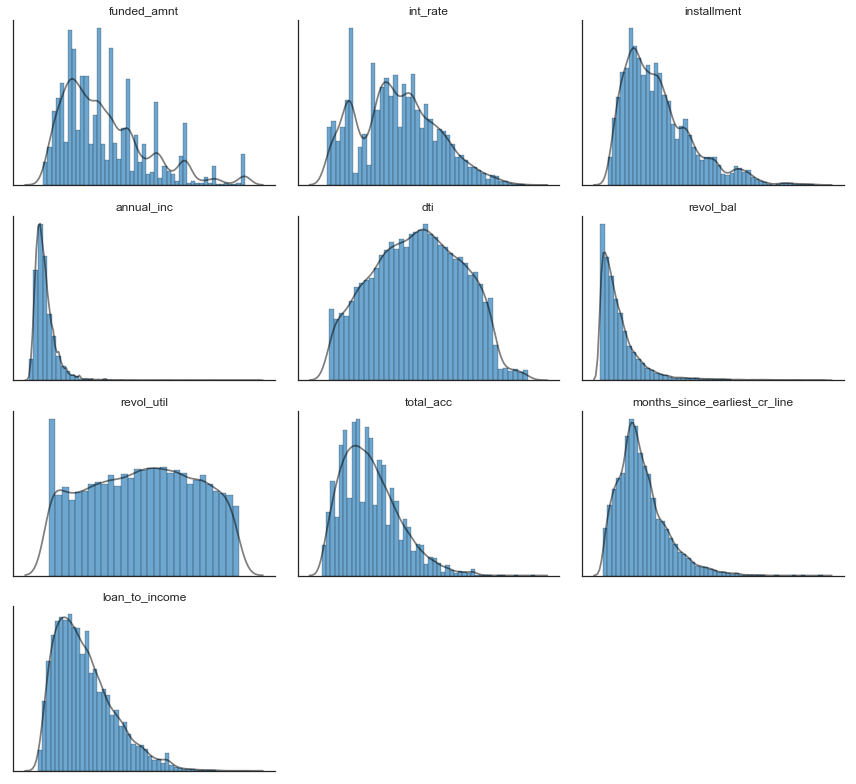

In [18]:
fig, axes = plt.subplots(4,3, figsize=(12,11))

for i, ax in enumerate(fig.axes):
    if i < len(continuous):
        sns.distplot(train[continuous[i]], ax=ax, hist_kws={'alpha': 0.65, 'edgecolor':'black', 'color' : colors1[0]},  
                     kde_kws={'color': 'black', 'alpha': 0.5})
        ax.set_xlabel('')
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(continuous[i])
    else:
        fig.delaxes(ax)

sns.despine()
plt.tight_layout()
plt.show()

The descriptive statistics further highlight these patterns. 

In [19]:
table = pd.DataFrame(train[continuous].skew().round(2), columns=['Skewness'])
table['Kurtosis'] = train[continuous].kurt().round(2)
table

,Skewness,Kurtosis
funded_amnt,1.09,0.95
int_rate,0.28,-0.49
installment,1.14,1.28
annual_inc,4.93,52.37
dti,-0.02,-0.83
revol_bal,3.25,15.23
revol_util,-0.05,-1.11
total_acc,0.83,0.68
months_since_earliest_cr_line,1.18,2.12
loan_to_income,0.98,0.88


We apply log and box transformations to reduce the skewness in some of the variables. We could also consider further transformations to other variables. 

In [20]:
train, test = log_transform('annual_inc', train, test)
train, test = log_transform('months_since_earliest_cr_line', train, test)
train, test = box_cox_transform('revol_bal', train, test, shift=1.0) # we add one to make the variable positive

Next, we plot univariate logistic regressions of te response and the predictors. All the relationships are as expected, with the interest rate and loan-to-income ratio displaying the variables with the largest coefficients. 

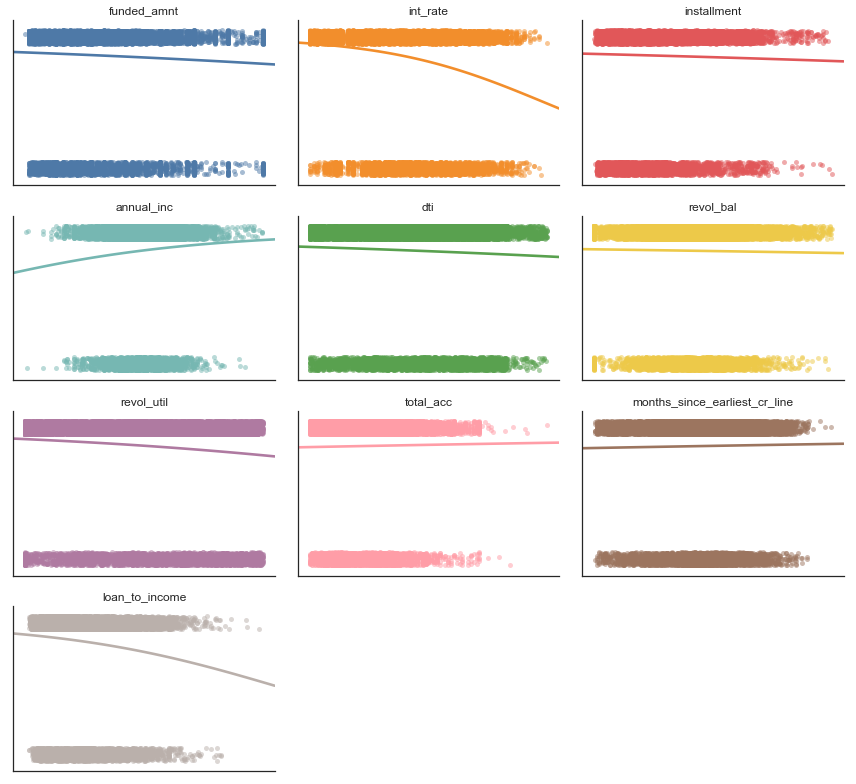

In [21]:
from statlearning import plot_logistic_regressions
plot_logistic_regressions(train[continuous], y_train)
plt.show()

The class-conditional distributions are mostly similar accross predictors. 

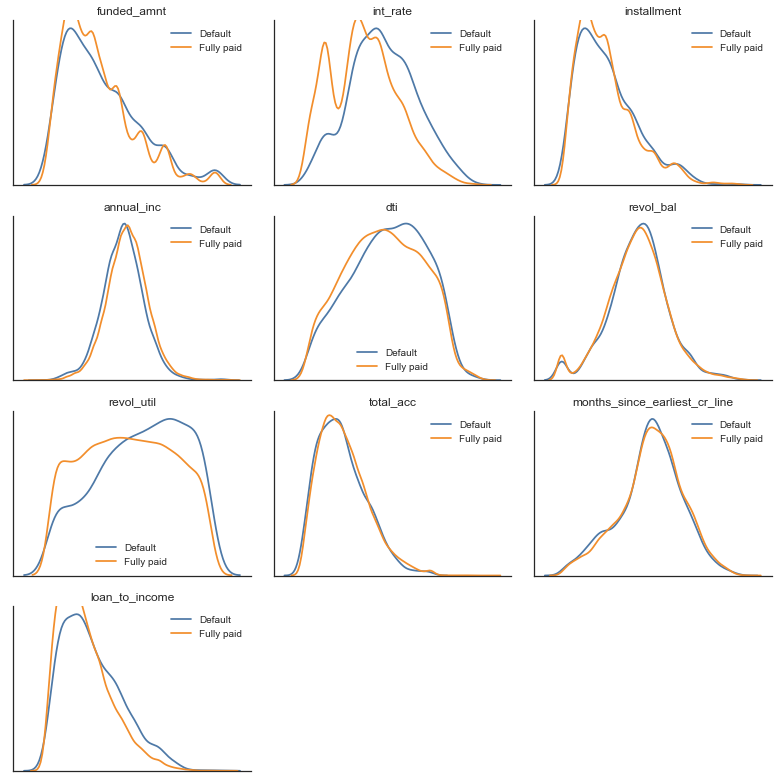

In [22]:
fig, axes = plt.subplots(4,3, figsize=(11,11))

for i, ax in enumerate(fig.axes):

    if i<len(continuous):
        sns.kdeplot(test.loc[y_test==0, continuous[i]], ax=ax, label='Default')
        sns.kdeplot(test.loc[y_test==1, continuous[i]], ax=ax, label='Fully paid')
        ax.set_xlabel('')
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(continuous[i])
    else:
        fig.delaxes(ax)

sns.despine()
plt.tight_layout()
plt.show()

Next, we consider the purpose of the loan, which is only categorial variable that was not pre-processed. Loans for educational and small businesses purposes seem to be riskier than  

In [23]:
train['purpose'].value_counts()

debt_consolidation    9183
credit_card           2460
other                 1953
home_improvement      1508
major_purchase        1051
small_business         899
car                    753
wedding                461
medical                353
moving                 264
vacation               201
house                  187
educational            152
renewable_energy        54
Name: purpose, dtype: int64

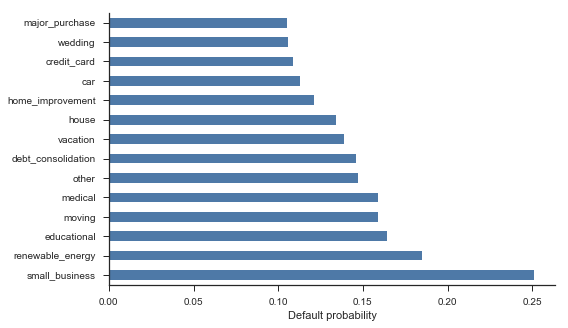

In [24]:
table = (1-train.groupby('purpose')['fully_paid'].mean()).sort_values(ascending=False).round(3)
fig, ax = plt.subplots(figsize=(8,5))
table.plot(kind='barh', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Default probability')
sns.despine()
plt.show()

We create the dummy variables for the categories below. Alternatively, we could also consider ordinal encoding for the tree-based methods. 

In [25]:
data.loc[data['purpose']=='renewable_energy']='other'
data.loc[data['purpose']=='vacation']='other'
data.loc[data['purpose']=='moving']='other'
data.loc[data['purpose']=='house']='other'

new_dummies = pd.get_dummies(data[['purpose']],  drop_first=True)
train=train.join(new_dummies.loc[index_train,:])
test=test.join(new_dummies.loc[index_test,:])

dummies+=list(new_dummies.columns)

Building the final design matrices: 

In [26]:
predictors = continuous + discrete + dummies

print('List of predictors: \n')
print(predictors)

X_train = train[predictors]
X_test = test[predictors]

X_train_tree = X_train.copy()
X_test_tree = X_test.copy()

mu= X_train.mean()
sigma= X_train.std()

X_train=(X_train-mu)/sigma
X_test=(X_test-mu)/sigma

List of predictors: 

['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_bal', 'revol_util', 'total_acc', 'months_since_earliest_cr_line', 'loan_to_income', 'emp_length', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'term_60', 'home_ownership_own', 'home_ownership_rent', 'verification_status_source verified', 'verification_status_verified', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_medical', 'purpose_other', 'purpose_small_business', 'purpose_wedding']


##Boosting

This section provides gradient boosting implementations based both [XGBoost](https://xgboost.readthedocs.io/en/latest/) and Scikit-Learn. XGBoost is the state of art algorithm for boosting and is very popular on Kaggle. 

Scroll below to use Scikit-Learn instead. 

In [27]:
import xgboost as xgb

In [28]:
%%time

model = xgb.XGBClassifier()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [100, 250, 500, 750],
    'max_depth' : [2,3,4,5]
}


bst =  GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, scoring='neg_log_loss', n_jobs=2)

bst.fit(X_train_tree, y_train)

Wall time: 22min 48s


In [29]:
bst.best_params_

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}

We use the XGBoost API directly to fine tune the number of iterations.

In [30]:
%%time

dtrain = xgb.DMatrix(X_train_tree, y_train)
dtest  = xgb.DMatrix(X_test_tree)

param = {
    'max_depth': 2, 
    'learning_rate': 0.05, 
    'silent' : 0, 
    'objective':'binary:logistic', 
    'eval_metric' : 'logloss', 
     }

cv = xgb.cv(param, dtrain, num_boost_round=1000, nfold=5, early_stopping_rounds=50)

print('Selected number of boosting iterations: {}'.format(cv.shape[0]))
print('Cross-entropy loss (CV): {:.4f}'.format(cv.iloc[-1,0]))

Selected number of boosting iterations: 310
Cross-entropy loss (CV): 0.3744
Wall time: 30.5 s


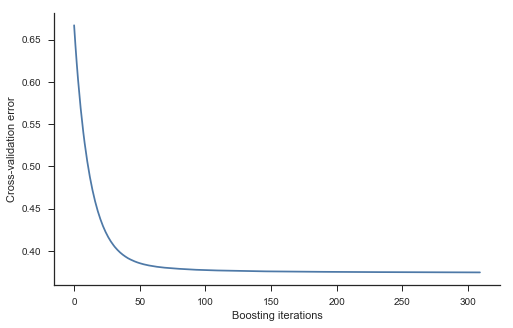

In [31]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(cv.iloc[:,0])
ax.set_ylabel('Cross-validation error')
ax.set_xlabel('Boosting iterations')
sns.despine()
plt.show()

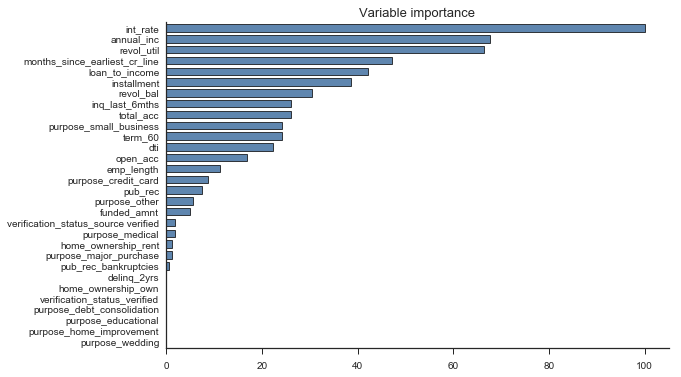

In [32]:
bst = xgb.XGBClassifier(learning_rate=0.05, n_estimators=310, max_depth=2)
bst.fit(X_train_tree, y_train)

plot_feature_importance(bst, labels=list(X_train_tree.columns))
plt.show()

Alternatively, using Scikit-Learn (uncomment to use it): 

In [33]:
# %%time

# model = GradientBoostingClassifier()

# tuning_parameters = {
#     'learning_rate': [0.001,0.01, 0.05, 0.1],
#     'n_estimators' : [100, 250, 500, 750, 1000, 1500],
#     'max_depth' : [2,3,4,5,6,7,8]
# }

# bst =  RandomizedSearchCV(model, tuning_parameters, cv=5, return_train_score=False, scoring='neg_log_loss', n_jobs=4,
#                         random_state=1)
# bst.fit(X_train_tree, y_train)


# plot_feature_importance(bst.best_estimator_, labels=list(X_train_tree.columns))
# plt.show()

# # Or: 
# GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3)
#

##Random forests

In [34]:
%%time

model = BaggingClassifier(DecisionTreeClassifier(), n_estimators=1000)

tuning_parameters = {
    'base_estimator__criterion' : ['entropy'],
    'base_estimator__min_samples_leaf': [1,5,10,20],
}

bag = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, scoring='neg_log_loss', n_jobs=2)
bag.fit(X_train_tree, y_train)

Wall time: 37min 18s


In [35]:
bag.best_params_

{'base_estimator__criterion': 'entropy',
 'base_estimator__min_samples_leaf': 20}

In [36]:
%%time

model = RandomForestClassifier(n_estimators=1000)

tuning_parameters = {
    'criterion' : ['entropy'],
    'min_samples_leaf': [1,5,10,20],
    'max_features': np.arange(3, len(predictors)),
}

rf = RandomizedSearchCV(model, tuning_parameters, cv=5, return_train_score=False, scoring='neg_log_loss', n_jobs=2)
rf.fit(X_train_tree, y_train)

Wall time: 55min 27s


In [37]:
rf.best_params_

{'criterion': 'entropy', 'max_features': 7, 'min_samples_leaf': 20}

In [38]:
rf = RandomForestClassifier(n_estimators=5000, max_features = rf.best_params_['max_features'], 
                           min_samples_leaf= rf.best_params_['min_samples_leaf'],  criterion= rf.best_params_['criterion'])
rf.fit(X_train_tree, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

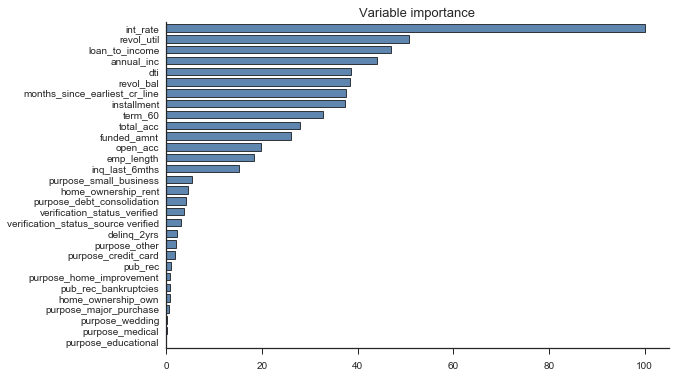

In [39]:
plot_feature_importance(rf, labels=list(X_train_tree.columns))
plt.show()

##Logistic regression

In [40]:
logit = LogisticRegression()
logit.fit(X_train, y_train)

logit_l1 = LogisticRegressionCV(penalty='l1', solver='liblinear')
logit_l1.fit(X_train, y_train)

logit_l2 = LogisticRegressionCV(penalty='l2')
logit_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [41]:
from statlearning import gam_design_matrix_test

nonlinear=['int_rate', 'annual_inc', 'revol_util', 'loan_to_income', 'revol_bal']
dfs=[5,5,5,5,5]
spline_dfs=dict(zip(nonlinear,dfs))

X_train_gam, X_test_gam = gam_design_matrix_test(X_train, X_test, spline_dfs)

logit_gam = LogisticRegression()
logit_gam.fit(X_train_gam, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##Model Stacking

In [42]:
%%time

from statlearning import stack_design_matrix, linear_probability_stack

rf_fast  = RandomForestClassifier(n_estimators=1000, max_features = rf.max_features, min_samples_leaf= rf.min_samples_leaf,  
                             criterion= 'entropy')

X_train_stack= stack_design_matrix([logit_gam, rf_fast, bst], [X_train, X_train_tree, X_train_tree],
                                   y_train, cv=5, prob=True)

Wall time: 3min 23s


In [43]:
stack = linear_probability_stack()
stack.fit(X_train_stack, y_train)
stack.weights.round(3)

## shortcut:
# stack = linear_probability_stack()
# stack.weights =  np.array([ 1/3,  1/3,  1/3])

array([ 0.333,  0.333,  0.333])

##Model evaluation

We first compute the predicted probabilites and decisions. 

In [44]:
methods=[logit, logit_l1, logit_l2, logit_gam, bag, rf, bst]

y_preds = np.zeros((len(y_test), len(methods)+2))
y_probs = np.zeros((len(y_test), len(methods)+2))

# constant probability model
y_probs[:,0] = np.mean(y_train) 
y_preds[:,0]  = (y_probs[:,0]>tau).astype(int)

# estimated models
for i, method in enumerate(methods):
    if i < 3:
        y_probs[:,i+1] = method.predict_proba(X_test)[:,1]
    elif i == 3:
        y_probs[:,i+1] = method.predict_proba(X_test_gam)[:,1]
    elif i < 7:
        y_probs[:,i+1] = method.predict_proba(X_test_tree)[:,1]
    else:
        y_probs[:,i+1] = method.predict_proba(X_test_tree)[:,1]
    
    y_preds[:,i+1]  = (y_probs[:,i+1]>tau).astype(int)

#  Linear stack
y_probs[:,-1] = stack.predict(y_probs[:,[4,6,7]])
y_preds[:,-1]  = (y_probs[:,-1]>tau).astype(int)

We evaluate all the models in terms of their investment performance on the entire test est.

(a) All classification methods substantially outperform the strategy of investing on all loans. <br/>

(b) The logistic GAM and the linear stack are the top performing methods, but all classification models have very similar overall performance. <br/>

(c) The average return across all loans invested is around 5.5% for all models. <br/>

(d) The bagging and random forest methods seem to lead to more conservative decisions than the other methods. <br/>


In [45]:
columns=['Frac Positive', 'Return on test set', 'Return given loan']

rows=['Invest in all', 'Constant probability', 'Logistic', 'L1 regularised', 'L2 regularised', 'Logistic GAM', 
      'Bagged trees', 'Random forest', 'Boosting', 'Linear Stack']

profitability =pd.DataFrame(0.0, columns=columns, index=rows)

for i in range(len(rows)):

    if i==0: 
        # invest in all 
        profitability.iloc[i,0] = 1.0
        profitability.iloc[i,1:3] = test['return'].mean()
        profitability.iloc[i,1:3] = test['return'].mean()
    else:
        profitability.iloc[i,0]= np.mean(y_preds[:,i-1])
        lp = y_preds[:,i-1]*test['return']
        ln = (1-y_preds[:,i-1])*(-loss_tn)  # the return from all the negatives is the same
        profitability.iloc[i,1]= np.mean(lp+ln)
        profitability.iloc[i,2] = np.sum(lp/np.sum(y_preds[:,i-1]))  
        
        expected = y_probs[:,i-1]*test['int_rate']+(1-y_probs[:,i-1])*(-loss_fp)

profitability.iloc[:,0]= profitability.iloc[:,0].round(3)
profitability.iloc[:,[1,2]]= (profitability.iloc[:,[1,2]]).round(2)    
profitability

,Frac Positive,Return on test set,Return given loan
Invest in all,1.000,3.27,3.27
Constant probability,0.515,3.00,2.71
Logistic,0.630,4.74,5.58
L1 regularised,0.631,4.75,5.59
L2 regularised,0.631,4.75,5.59
Logistic GAM,0.639,4.77,5.60
Bagged trees,0.580,4.43,5.24
Random forest,0.579,4.50,5.36
Boosting,0.630,4.73,5.56
Linear Stack,0.615,4.79,5.71


Next, we consider the traditional classification metrics. In order to draw a meaningful comparison betweeen we give higher weights to defaults when computing the error rate, the area under the ROC curve, and the area under the precision-recall curve. 

Based on the specificity, the classification models avoid around 55-60% of defaults. 

In [46]:
columns=['Weighted error rate', 'Sensitivity', 'Specificity', 'Weighted AUC', 'Precision', 'Weighted AUPRC', 'Cross-entropy']

rows=['Constant probability', 'Logistic', 'L1 regularised', 'L2 regularised','Logistic GAM', 
      'Bagged trees', 'Random forest', 'Boosting',  'Linear Stack']

results=pd.DataFrame(0.0, columns=columns, index=rows)

weights=y_test*(test['return']+loss_fn)+(1-y_test)*(loss_fp-loss_tn)
    
for i in range(len(rows)):
    confusion  = confusion_matrix(y_test,  y_preds[:,i]) 
    results.iloc[i,0]=  1 - accuracy_score(y_test, y_preds[:,i], sample_weight=weights)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,3]=  roc_auc_score(y_test, y_probs[:,i], sample_weight=weights)
    results.iloc[i,4]=  precision_score(y_test, y_preds[:,i])
    results.iloc[i,5]=  average_precision_score(y_test,  y_probs[:,i], sample_weight=weights)
    results.iloc[i,6]=  log_loss(y_test,  y_probs[:,i])

results.round(3)

,Weighted error rate,Sensitivity,Specificity,Weighted AUC,Precision,Weighted AUPRC,Cross-entropy
Constant probability,0.518,0.485,0.302,0.500,0.810,0.502,0.406
Logistic,0.404,0.662,0.570,0.608,0.904,0.599,0.375
L1 regularised,0.403,0.663,0.569,0.608,0.904,0.599,0.375
L2 regularised,0.403,0.663,0.569,0.608,0.904,0.599,0.375
Logistic GAM,0.403,0.673,0.573,0.609,0.906,0.596,0.375
Bagged trees,0.421,0.610,0.599,0.592,0.903,0.590,0.380
Random forest,0.418,0.608,0.598,0.597,0.903,0.594,0.377
Boosting,0.406,0.663,0.572,0.604,0.905,0.594,0.375
Linear Stack,0.402,0.649,0.595,0.606,0.907,0.597,0.375


All the models have very similar ROC curves. 

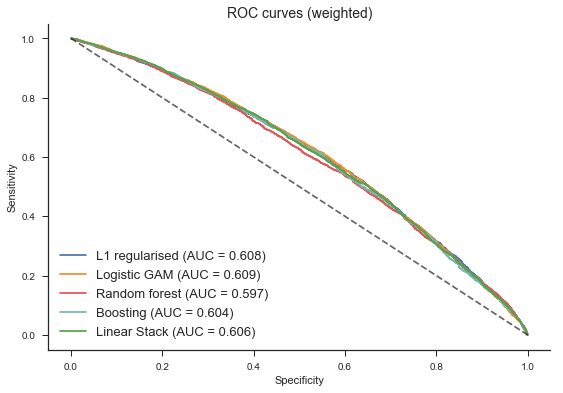

In [47]:
from statlearning import plot_roc_curves

fig, ax = plot_roc_curves(y_test, y_probs[:,[2,4,6,7,8]], labels=pd.Series(rows).iloc[[2,4,6,7,8]], sample_weight=weights)
ax.set_title('ROC curves (weighted)', fontsize=14)
plt.show()

##Investment strategy

In the previous section, we considered the performance of our models across the entire test set. A better strategy for an individual investor participating in the peer-to-peer lending platform is to invest a portfolio of loans that have the highest expected return, with sufficient diversification to dilute the risk from defaults.

We implement this strategy for a portfolio size of 1000 loans, where we assume an equal investment in each loan.  The gradient boosting model achieves the best rate of return. 

In [48]:
columns=['Return', 'SE']

rows=['Constant', 'Logistic', 'L1 regularised', 'L2 regularised', 'Logistic GAM', 
      'Bagged trees', 'Random forest', 'Boosting', 'Linear Stack']

strategy  = pd.DataFrame(0.0, columns=columns, index=rows)

loans = 1000 # portfolio size

for i in range(len(rows)):
 
    expected = y_probs[:,i]*test['int_rate']+(1-y_probs[:,i])*(-loss_fp)
    expected   = expected.sort_values(ascending=False)
    strategy.iloc[i,0] = test.loc[expected.index[:loans],'return'].mean()
    strategy.iloc[i,1] = test.loc[expected.index[:loans],'return'].std()/np.sqrt(loans)

strategy.round(2)

,Return,SE
Constant,-0.51,1.22
Logistic,8.26,0.71
L1 regularised,8.26,0.71
L2 regularised,8.27,0.71
Logistic GAM,7.59,0.77
Bagged trees,7.12,0.74
Random forest,7.99,0.67
Boosting,8.52,0.69
Linear Stack,8.44,0.68


The rate of return depends on the portfolio size. Below, we plot the investment performance of different models as we vary the portfolio size. The tree-based methods perform best for smaller portfolio sizes, while the logistic GAM performs best for larger portfolios.  The linear stack is a compromise. 

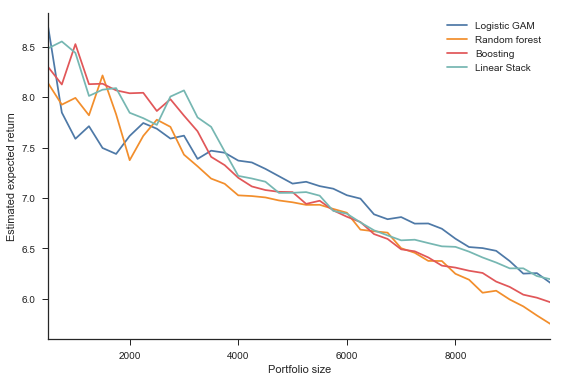

In [49]:
models = ['Constant', 'Logistic', 'L1 regularised', 'L2 regularised', 'Logistic GAM', 
      'Bagged trees', 'Random forest', 'Boosting', 'Linear Stack']

sizes = np.arange(500, 10000, 250)

returns = np.zeros((len(sizes), len(rows))) 

for i, loans in enumerate(sizes):
    for j in range(len(rows)):
        expected =   y_probs[:,j]*test['int_rate']+(1-y_probs[:,j])*(-loss_fp)
        expected  = expected.sort_values(ascending=False)
        returns[i,j] = test.loc[expected.index[:loans],'return'].mean()

returns = pd.DataFrame(returns, columns=models, index=sizes)

fig, ax = plt.subplots(figsize=(9,6))
returns[['Logistic GAM', 'Random forest', 'Boosting', 'Linear Stack']].plot(ax=ax)
ax.set_xlabel('Portfolio size')
ax.set_ylabel('Estimated expected return')
ax.set_title('')
plt.legend()
sns.despine()
plt.show()

How risky is this investment strategy? We can use the bootstrap method to estimate the distribution of the return of the portfolio. 

Our results in the next cell are an approximation only, since we do not take into account the uncertainty in the the portfolio selection strategy. 

Furthermore, we can only estimate the static cross sectional variability in the loans, but should also take into account the systematic risk in the default rates. 

Portfolio size = 5000
Average return = 7.05
Bootstrap t interval (99%) = (6.25, 7.76)


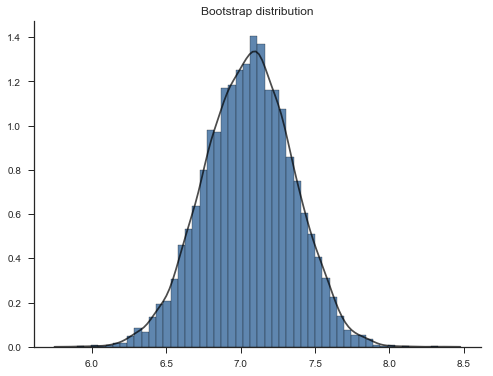

In [50]:
from statlearning import bootstrap_mean, plot_histogram

# Try to vary the portfolio size
# The return distribution is negatively skewed for small portfolios
loans = 5000

expected = y_probs[:,-1]*test['int_rate']+(1-y_probs[:,-1])*(-loss_fp)
expected   = expected.sort_values(ascending=False)
returns = test.loc[expected.index[:loans],'return'] # return sample for the selected loans

mean_boot, ci_low, ci_high = bootstrap_mean(returns, S=10000, alpha=0.01)

print('Portfolio size = {}'.format(loans))
print('Average return = {0:.2f}'.format(np.mean(returns)))
print(r'Bootstrap t interval (99%) = ({0:.2f}, {1:.2f})'.format(ci_low, ci_high))

fig, ax = plot_histogram(mean_boot)
ax.set_title('Bootstrap distribution')
plt.show()

##Limitations

Keep in mind the following limitations of our analysis. 

(a) We do not take the loss function into account at the training and model selection stages. <br/>

(b) The logistic GAM is not based on model selection. <br/>

(c) We do not estimate the optimal coefficients for model stacking. <br/>

(d) We do not consider statistical significance when comparing the performance of different models for the investment strategy.  <br/>